  BOE 2024 - Preparación de dataset numérico (SIN sentimiento)

  + integración de tópicos y agregación semanal (1 fila por semana)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# -----------------------------
# 1. Cargar dataset limpio BOE
# -----------------------------
ruta_a = "data/boe_2024_clean.parquet"
df_clean = pd.read_parquet(ruta_a)

print("✅ Archivo BOE limpio cargado correctamente")
print("Shape df_clean:", df_clean.shape)
print(df_clean.head(3))


✅ Archivo BOE limpio cargado correctamente
Shape df_clean: (27622, 8)
  identificador      fecha                                     seccion_nombre  \
0  BOE-A-2024-1 2024-01-01  II. Autoridades y personal. - A. Nombramientos...   
1  BOE-A-2024-2 2024-01-01  II. Autoridades y personal. - A. Nombramientos...   
2  BOE-A-2024-3 2024-01-01  II. Autoridades y personal. - A. Nombramientos...   

                       departamento_nombre epigrafe_nombre  \
0  MINISTERIO DE TRABAJO Y ECONOMÍA SOCIAL        Destinos   
1                            UNIVERSIDADES   Nombramientos   
2                            UNIVERSIDADES   Nombramientos   

                                              titulo  \
0  Resolución de 21 de diciembre de 2023, de la S...   
1  Resolución de 21 de diciembre de 2023, de la U...   
2  Resolución de 22 de diciembre de 2023, conjunt...   

                                        texto_limpio      mes  
0  Por Resolución de la Subsecretaría de este Dep...  2024-01  
1  

In [3]:
# Asegurar tipo datetime en 'fecha'
df_clean["fecha"] = pd.to_datetime(df_clean["fecha"], errors="coerce")

print("Fechas únicas:", df_clean["fecha"].nunique())
print("Semanas ISO únicas:", df_clean["fecha"].dt.isocalendar().week.nunique())


Fechas únicas: 314
Semanas ISO únicas: 52


In [4]:
df_clean["epigrafe_nombre"].unique()

<StringArray>
[                                                                  'Destinos',
                                                              'Nombramientos',
                               'Funcionarios de la Administración del Estado',
                              'Funcionarios de las Administraciones Públicas',
 'Funcionarios de administración local con habilitación de carácter nacional',
                              'Funcionarios de los Subgrupos A1, A2, C1 y C2',
                                                       'Personal funcionario',
                                             'Personal funcionario y laboral',
                                            'Cuerpos docentes universitarios',
                                                             'Homologaciones',
 ...
                                                                    'Energía',
                                              'Capital Europea de la Cultura',
                                 

In [5]:
# Crear columna de semana ISO
df_clean["semana"] = df_clean["fecha"].dt.isocalendar().week.astype(int)

# -----------------------------
# 2. Cargar archivo de tópicos
# -----------------------------
ruta_topicos = "data/boe_2024_predicciones_embeddings.csv"
df_topics = pd.read_csv(ruta_topicos)

print("✅ Archivo de tópicos cargado correctamente")
print("Shape df_topics:", df_topics.shape)
print(df_topics.head(5))

# IMPORTANTE:
# Asumo que en df_topics hay una columna con el identificador BOE
# y otra con el tópico, por ejemplo:
#   identificador | topico
#
# Si los nombres son distintos, AJUSTA aquí:
col_id_topics_posibles = ["identificador", "id_boe", "boe_id", "id"]
col_topic_posibles = ["topico", "tema", "topic", "prediccion", "categoria"]

id_col = next((c for c in col_id_topics_posibles if c in df_topics.columns), None)
topic_col = next((c for c in col_topic_posibles if c in df_topics.columns), None)

if id_col is None or topic_col is None:
    raise ValueError(
        f"No encuentro columnas de identificador/tópico en df_topics. "
        f"Columnas disponibles: {df_topics.columns}"
    )

# Renombrar para trabajar siempre con los mismos nombres
df_topics = df_topics.rename(columns={id_col: "identificador", topic_col: "topico"})

print("Columnas tras renombrar en df_topics:", df_topics.columns)


✅ Archivo de tópicos cargado correctamente
Shape df_topics: (75443, 2)
  identificador                          prediccion
0  BOE-A-2024-1        Empleo Publico y Oposiciones
1  BOE-A-2024-2  Administracion y Legislacion Civil
2  BOE-A-2024-3  Administracion y Legislacion Civil
3  BOE-A-2024-4  Administracion y Legislacion Civil
4  BOE-A-2024-5  Administracion y Legislacion Civil
Columnas tras renombrar en df_topics: Index(['identificador', 'topico'], dtype='object')


In [6]:
# -----------------------------
# 3. Unir tópicos al BOE limpio
# -----------------------------
# df_clean debe tener también la columna 'identificador'
if "identificador" not in df_clean.columns:
    raise ValueError("df_clean no tiene columna 'identificador'. Ajusta el nombre según tu parquet.")

df_merged = df_clean.merge(
    df_topics[["identificador", "topico"]],
    on="identificador",
    how="left"  # Nos quedamos con las filas que ya tenías en df_clean
)

print("✅ Merge realizado")
print("Shape df_merged:", df_merged.shape)
print(df_merged[["identificador", "topico"]].head(10))

# Opcional: comprobar cuántos sin tópico
sin_topico = df_merged["topico"].isna().sum()
print(f"Filas sin tópico asignado (NaN): {sin_topico}")


✅ Merge realizado
Shape df_merged: (27622, 10)
   identificador                              topico
0   BOE-A-2024-1        Empleo Publico y Oposiciones
1   BOE-A-2024-2  Administracion y Legislacion Civil
2   BOE-A-2024-3  Administracion y Legislacion Civil
3   BOE-A-2024-4  Administracion y Legislacion Civil
4   BOE-A-2024-5  Administracion y Legislacion Civil
5   BOE-A-2024-6  Administracion y Legislacion Civil
6   BOE-A-2024-7  Administracion y Legislacion Civil
7   BOE-A-2024-8  Administracion y Legislacion Civil
8   BOE-A-2024-9  Administracion y Legislacion Civil
9  BOE-A-2024-10  Administracion y Legislacion Civil
Filas sin tópico asignado (NaN): 0


In [7]:
# -----------------------------
# 4. Conteos por semana (para info)
# -----------------------------
conteo_semana_simple = (
    df_merged.groupby("semana", as_index=False)["identificador"]
             .count()
             .rename(columns={"identificador": "publicaciones_semana"})
)

print("📊 Estadísticas de publicaciones por semana:")
print(conteo_semana_simple["publicaciones_semana"].describe())
print(conteo_semana_simple.head())


📊 Estadísticas de publicaciones por semana:
count     52.000000
mean     531.192308
std       96.537311
min      281.000000
25%      485.250000
50%      534.000000
75%      597.250000
max      749.000000
Name: publicaciones_semana, dtype: float64
   semana  publicaciones_semana
0       1                   618
1       2                   323
2       3                   378
3       4                   476
4       5                   524


In [17]:
conteo_semana = (
    df_clean.groupby(df_clean["fecha"].dt.to_period("W"))["identificador"]
      .count()
      .reset_index(name="publicaciones")
)

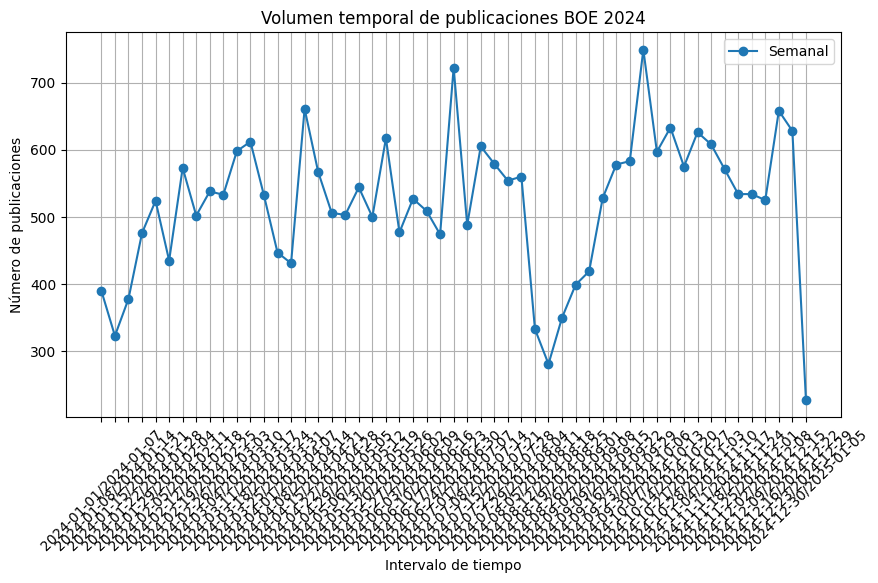

In [19]:
# Visualización básica de volumen temporal
plt.figure(figsize=(10, 5))
plt.plot(conteo_semana["fecha"].astype(str), conteo_semana["publicaciones"],
         label="Semanal", marker="o")
plt.legend()
plt.title("Volumen temporal de publicaciones BOE 2024")
plt.xlabel("Intervalo de tiempo")
plt.ylabel("Número de publicaciones")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [8]:
# -----------------------------
# 5. One-hot encoding (incluyendo tópicos)
# -----------------------------
# Columnas categóricas a transformar en dummies
cols_to_encode = ['seccion_nombre', 'departamento_nombre', 'epigrafe_nombre', 'topico']

# Primero nos aseguramos de que existan (las que no, se ignoran)
cols_to_encode = [c for c in cols_to_encode if c in df_merged.columns]
print("Columnas que se van a one-hot-encodear:", cols_to_encode)

df_encoded = pd.get_dummies(df_merged, columns=cols_to_encode, prefix=cols_to_encode)

print("✅ One-hot encoding completado")
print(df_encoded.head())
print("Shape df_encoded:", df_encoded.shape)


Columnas que se van a one-hot-encodear: ['seccion_nombre', 'departamento_nombre', 'epigrafe_nombre', 'topico']
✅ One-hot encoding completado
  identificador      fecha                                             titulo  \
0  BOE-A-2024-1 2024-01-01  Resolución de 21 de diciembre de 2023, de la S...   
1  BOE-A-2024-2 2024-01-01  Resolución de 21 de diciembre de 2023, de la U...   
2  BOE-A-2024-3 2024-01-01  Resolución de 22 de diciembre de 2023, conjunt...   
3  BOE-A-2024-4 2024-01-01  Resolución de 22 de diciembre de 2023, de la U...   
4  BOE-A-2024-5 2024-01-01  Resolución de 22 de diciembre de 2023, de la U...   

                                        texto_limpio      mes  semana  \
0  Por Resolución de la Subsecretaría de este Dep...  2024-01       1   
1  Vistas las propuestas elevadas por las comisio...  2024-01       1   
2  Vista la propuesta elevada el 18 de diciembre ...  2024-01       1   
3  De conformidad con la propuesta elevada por la...  2024-01       1   
4  De c

In [9]:
# -----------------------------
# 6. Construir dataset numérico por FILA (artículo)
#    (similar a lo que ya tenías)
# -----------------------------
cols_to_drop_articulo = [
    "identificador", "fecha", "titulo", "texto_limpio",
    "mes", "sentimiento_num"  # 'mes' y 'sentimiento_num' se ignoran si no existen
]

df_articulo = df_encoded.drop(columns=cols_to_drop_articulo, errors="ignore")

# Si tienes una columna 'conteo_semana' previa, la elimino para que no distorsione al agrupar más tarde
df_articulo = df_articulo.drop(columns=["conteo_semana"], errors="ignore")

print("✅ Dataset numérico por artículo preparado")
print(df_articulo.head())
print("Shape df_articulo:", df_articulo.shape)

# Guardar por si lo quieres conservar
out_path_articulo = "dataset_boe_temporal_sin_sentimiento_por_articulo_con_topico.csv"
df_articulo.to_csv(out_path_articulo, index=False)
print(f"💾 Dataset por ARTÍCULO guardado en: {out_path_articulo}")


✅ Dataset numérico por artículo preparado
   semana  seccion_nombre_I. Disposiciones generales  \
0       1                                      False   
1       1                                      False   
2       1                                      False   
3       1                                      False   
4       1                                      False   

   seccion_nombre_II. Autoridades y personal. - A. Nombramientos, situaciones e incidencias  \
0                                               True                                          
1                                               True                                          
2                                               True                                          
3                                               True                                          
4                                               True                                          

   seccion_nombre_II. Autoridades y personal. - B.

In [10]:
# -----------------------------
# 7. Agregación semanal (1 fila por semana)
# -----------------------------
# Ahora creamos un dataset con:
#  - 'semana' (clave temporal)
#  - conteos por cada dummy (secciones, departamentos, epígrafes, tópicos...)
#  - número total de publicaciones en la semana

# Aseguramos que 'semana' está en df_articulo
if "semana" not in df_articulo.columns:
    raise ValueError("La columna 'semana' no está en df_articulo. Revisa pasos anteriores.")

# Separamos la columna de la clave de las columnas numéricas a sumar
numeric_cols = [c for c in df_articulo.columns if c != "semana"]

df_semana = (
    df_articulo.groupby("semana", as_index=False)[numeric_cols]
               .sum()   # sumamos los dummies -> conteos por semana
)

# Añadir columna de conteo total de publicaciones por semana (por claridad)
conteo_publicaciones = (
    df_merged.groupby("semana", as_index=False)["identificador"]
             .nunique()
             .rename(columns={"identificador": "publicaciones_semana"})
)

df_semana = df_semana.merge(conteo_publicaciones, on="semana", how="left")

print("✅ Dataset numérico AGREGADO por semana preparado (1 fila por semana)")
print(df_semana.head())
print("Shape df_semana:", df_semana.shape)


✅ Dataset numérico AGREGADO por semana preparado (1 fila por semana)
   semana  seccion_nombre_I. Disposiciones generales  \
0       1                                         22   
1       2                                         20   
2       3                                         21   
3       4                                         22   
4       5                                         27   

   seccion_nombre_II. Autoridades y personal. - A. Nombramientos, situaciones e incidencias  \
0                                                 55                                          
1                                                 84                                          
2                                                 79                                          
3                                                 72                                          
4                                                 87                                          

   seccion_nombre_II. A

In [11]:
# -----------------------------
# 8. Exportar dataset final semanal
# -----------------------------
out_path_semana = "dataset_boe_temporal_sin_sentimiento_por_semana_con_topico.csv"
df_semana.to_csv(out_path_semana, index=False)

print(f"💾 Dataset numérico SEMANAL (1 fila/semana) guardado en: {out_path_semana}")


💾 Dataset numérico SEMANAL (1 fila/semana) guardado en: dataset_boe_temporal_sin_sentimiento_por_semana_con_topico.csv
